# Monte Carlo simulation

In [5]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import math

In [6]:
import datetime
import pandas_datareader as pdr
import datetime
import yfinance as yf
%matplotlib inline

## Show historical TSLA stock price

In [7]:
start_date=datetime.datetime(2017,11,28)
end_date=datetime.datetime(2023,11,28)
tickers = 'TSLA'
prices = yf.download(tickers, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [8]:
historical = prices['Adj Close'].dropna(how='all')
historical

Date
2017-11-28     21.170000
2017-11-29     20.502666
2017-11-30     20.590000
2017-12-01     20.435333
2017-12-04     20.346666
                 ...    
2023-11-20    235.600006
2023-11-21    241.199997
2023-11-22    234.210007
2023-11-24    235.449997
2023-11-27    236.080002
Name: Adj Close, Length: 1509, dtype: float64

In [9]:
ret = historical.pct_change()[1:] #daily returns for the month
ret

Date
2017-11-29   -0.031523
2017-11-30    0.004260
2017-12-01   -0.007512
2017-12-04   -0.004339
2017-12-05   -0.004915
                ...   
2023-11-20    0.005548
2023-11-21    0.023769
2023-11-22   -0.028980
2023-11-24    0.005294
2023-11-27    0.002676
Name: Adj Close, Length: 1508, dtype: float64

In [10]:
days = len(ret)
sample_mean_tsla = np.mean(ret)
sample_std_tsla = np.std(ret, ddof=1)

sample_mean_tsla,sample_std_tsla

(0.0024043663221886644, 0.040156388904390154)

In [11]:
sample_variance_tsla=sample_std_tsla**2
sample_variance_tsla

0.0016125355698406287

In [12]:
lastPrice= S0 = historical.iloc[-1]
S0

236.0800018310547

## European Option

### Monte Carlo Simulation

In [13]:
def monte_carlo_option_price(S, K, r, T, vol, num_simulations):
    dt = 1/252  # Time step, assuming 252 trading days
    num_days = int(T * 252)  # Number of days until expiration

    simulated_prices = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        price_path = np.zeros(num_days )
        price_path[0] = S

        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_t = price_path[day - 1] * np.exp(drift + diffusion)
            price_path[day] = price_t

        simulated_prices[i, :] = price_path

    option_payoffs = np.maximum(simulated_prices[:, -1] - K, 0)  # Payoff at expiration
    option_price = np.exp(-r * T) * np.mean(option_payoffs)

    return option_price, simulated_prices

In [14]:
# Option parameters
S = S0  # Current stock price
K = 260  # Strike price
r = 0.05045  # Risk-free interest rate
T = 1  # Time to expiration (in years)
vol = sample_std_tsla  # Volatility
num_simulations = 1000 # Number of Monte Carlo simulations

#potremmo definire diversamente il tempo, per esempio possiamo valutare sempre opzioni di un anno e dividere il numero di giorni per il numero di step in cui puoi ricattare l'opzione

In [15]:
# European Call Option Price with Monte Carlo Simulation
option_price, price_paths = monte_carlo_option_price(S, K, r, T, vol, num_simulations)

# Stampa del prezzo dell'opzione e visualizzazione dei path
print("Prezzo dell'opzione:", option_price)



Prezzo dell'opzione: 0.5852626516426007


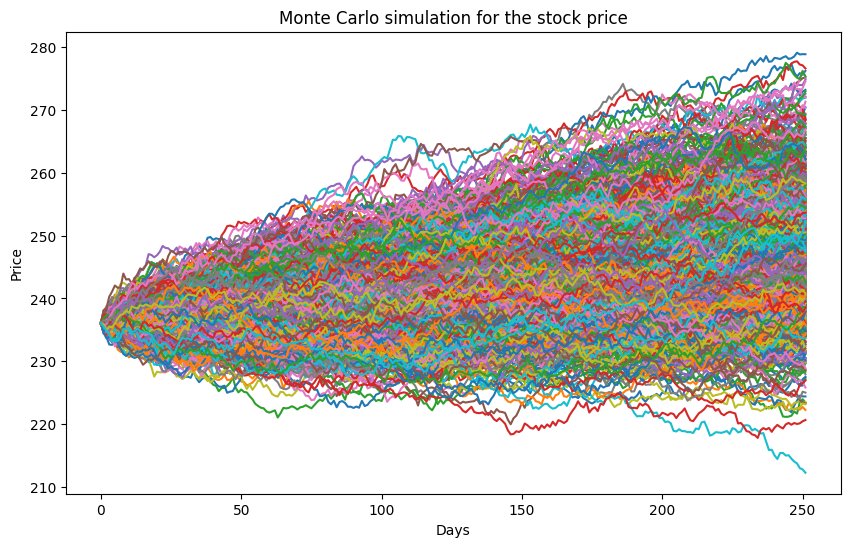

In [16]:
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(price_paths[i, :], label=f'Simulazione {i + 1}')

plt.title('Monte Carlo simulation for the stock price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

### Binary tree


In [17]:
N=36
T=1
dt=T/N
S = S0
K = 260
r = 0.05045
u = np.exp(sample_std_tsla * np.sqrt(dt)) #Cox, Ross and Rubinstein (CRR)
d = 1/u

In [18]:
def binomial_tree_slow(K,T,S0,r,N,u,d,opttype='C'):
    #precompute constants
    dt = T/N
    q = (np.exp(r*dt) - d) / (u-d)
    disc = np.exp(-r*dt)

    # initialise asset prices at maturity - Time step N
    S = np.zeros(N+1)
    S[0] = S0*d**N #you are taking the worst scenario 
    for j in range(1,N+1):
        S[j] = S[j-1]*u/d  # you're doing like a zig zag at time T to obtain all the prices

    # initialise option values at maturity
    C = np.zeros(N+1)
    for j in range(0,N+1):
        C[j] = max(0, S[j]-K)

    # step backwards through tree
    for i in np.arange(N,0,-1):
        for j in range(0,i):
            C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )

    return C[0]

binomial_tree_slow(K,T,S,r,N,u,d,opttype='C')

0.5318703931520848

In [19]:
def binomial_tree_fast(K,T,S0,r,N,u,d,opttype='C'):
    #precompute constants
    dt = T/N
    q = (np.exp(r*dt) - d) / (u-d)
    disc = np.exp(-r*dt)

    # initialise asset prices at maturity - Time step N
    C = S0 * d ** (np.arange(N,-1,-1)) * u ** (np.arange(0,N+1,1))

    # initialise option values at maturity
    C = np.maximum( C - K , np.zeros(N+1) )

    # step backwards through tree
    for i in np.arange(N,0,-1):
        C = disc * ( q * C[1:i+1] + (1-q) * C[0:i] )

    return C[0]

binomial_tree_fast(K,T,S,r,N,u,d,opttype='C')
     

0.5318703931520933

## American Option


### Monte Carlo

Mancante

### Binary Tree

In [20]:
def american_slow_tree(K,T,S0,r,N,u,d,opttype='P'):
    #precompute values
    dt = T/N
    q = (np.exp(r*dt) - d)/(u-d)
    disc = np.exp(-r*dt)

    # initialise stock prices at maturity
    S = np.zeros(N+1)
    for j in range(0, N+1):
        S[j] = S0 * u**j * d**(N-j)

    # option payoff
    C = np.zeros(N+1)
    for j in range(0, N+1):
        if opttype == 'P':
            C[j] = max(0, K - S[j])
        else:
            C[j] = max(0, S[j] - K)

    # backward recursion through the tree
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            S = S0 * u**j * d**(i-j)
            C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )
            if opttype == 'P':
                C[j] = max(C[j], K - S)
            else:
                C[j] = max(C[j], S - K)

    return C[0]

american_slow_tree(K,T,S0,r,N,u,d,opttype='P')  

23.919998168945312

In [21]:
def american_fast_tree(K,T,S0,r,N,u,d,opttype='P'):
    #precompute values
    dt = T/N
    q = (np.exp(r*dt) - d)/(u-d)
    disc = np.exp(-r*dt)

    # initialise stock prices at maturity
    S = S0 * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))

    # option payoff
    if opttype == 'P':
        C = np.maximum(0, K - S)
    else:
        C = np.maximum(0, S - K)

    # backward recursion through the tree
    for i in np.arange(N-1,-1,-1):
        S = S0 * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
        C[:i+1] = disc * ( q*C[1:i+2] + (1-q)*C[0:i+1] )
        C = C[:-1]
        if opttype == 'P':
            C = np.maximum(C, K - S)
        else:
            C = np.maximum(C, S - K)

    return C[0]

Problema con l'opzione americana -> più è grande N e più alto risulta il prezzo dell'opzione.
L'opzione americana può essere riscattata in qualsiasi momento quindi ha una finestra temporale pressocchè infinita. Come gestiamo sta cosa?


## American Digital Option


L'american digital option funziona che ha un pagamento fisso ad una data prefissata, questo pagamento avviene se il prezzo del sottostante asset soddisfa un certo criterio (per esempio se raggiunge un certo prezzo). Non deve soddisfarlo alla scadenza, basat che nella durata dell'opzione almeno una volta l'abbia soddisfatto.


Come procederei? attraverso il metodo di montecarlo ricreando il moto browniano del prezzo dell'opzione sceglierei un livello di prezzo K, si conta il nunero di simulazioni che hanno soddisfatto questo requisito e si calcola il payout medio che si sconterà e dovrà essere uguae al tasso risk free.

## Montecarlo method

In [22]:
def monte_carlo_digital_option_price(S, K, r, T, vol, num_simulations):
    dt = 1/252  # Time step, assuming 252 trading days
    num_days = int(T * 252)  # Number of days until expiration

    simulated_prices = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        price_path = np.zeros(num_days )
        price_path[0] = S

        for day in range(1, num_days):
            drift = (r - 0.5 * vol ** 2) * dt
            diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
            price_t = price_path[day - 1] * np.exp(drift + diffusion)
            price_path[day] = price_t

        simulated_prices[i, :] = price_path

        if np.max(simulated_prices) >= K:
            simulated_prices[i] = 1  # Paga $1 se la condizione è soddisfatta
        else:
            simulated_prices[i] = 0  # Altrimenti, paga $0
    option_price = np.exp(-r * T) * np.mean(simulated_prices)

    return option_price

In [23]:
# Option parameters
S = S0  # Current stock price
K = 260  # Strike price
r = 0.05045  # Risk-free interest rate
T = 1  # Time to expiration (in years)
vol = sample_std_tsla  # Volatility
num_simulations = 1000 # Number of Monte Carlo simulations

In [24]:
print("Prezzo dell'opzione:", monte_carlo_digital_option_price(S, K, r, T, vol, num_simulations))

Prezzo dell'opzione: 0.1549806392118273


## Binary tree

In [ ]:
# Da modificare ho solo incollato il codice dell'american option è da modificare per renderlo una digital option

def digital_american_tree(K,T,S0,r,N,u,d):
    #precompute values
    dt = T/N
    q = (np.exp(r*dt) - d)/(u-d)
    disc = np.exp(-r*dt)

    # initialise stock prices at maturity
    S = np.zeros(N+1)
    for j in range(0, N+1):
        S[j] = S0 * u**j * d**(N-j)

    # option payoff
    C = np.zeros(N+1)
    for j in range(0, N+1):
        if opttype == 'P':
            C[j] = max(0, K - S[j])
        else:
            C[j] = max(0, S[j] - K)

    # backward recursion through the tree
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            S = S0 * u**j * d**(i-j)
            C[j] = disc * ( q*C[j+1] + (1-q)*C[j] )
            if opttype == 'P':
                C[j] = max(C[j], K - S)
            else:
                C[j] = max(C[j], S - K)

    return C[0]

digital_american_tree(K,T,S0,r,N,u,d)  

#idea: provare a vedere quanti nodi ci sono in un albero e vedere quanti di queti sono maggiori di K?

## Knock Out Option

* A knock-out option is a type of barrier option. Barrier options are typically classified as either knock-out or knock-in.
* A knock-out option ceases to exist if the underlying asset reaches a predetermined barrier during its life.
* The two types of knock-out options are up-and-out barrier options and down-and-out options.
* Knock-out options limit losses, but also potential profits.-

A down-and-out option is one variety. It gives the holder the right, but not the obligation, to purchase or sell an underlying asset at a predetermined strike price—if the underlying asset's price does not go below a specified barrier during the option's life. Should the underlying asset's price fall below the barrier at any point in the option's life, the option expires worthless.

For example, assume an investor purchases a down-and-out call option on a stock that is trading at $60, with a strike price of $55 and a barrier of $50. If the stock trades below $50, at any time, before the call option expires then the down-and-out call option promptly ceases to exist. 



Contrary to a down-and-out barrier option, an up-and-out barrier option gives the holder the right to buy or sell an underlying asset at a specified strike price if the asset has not exceeded a specified barrier during the option's life. An up-and-out option is only knocked out if the price of the underlying asset moves above the barrier.

Assume an investor purchases an up-and-out put option on a stock trading at $40, with a strike price of $30 and a barrier of $45. Over the life of the option, the stock hits a high of $46 but then drops to $20 per share. Too bad: the option still would automatically expire because the barrier of $45 had been breached. Now, if the stock hadn't gone above $45 and eventually sold off to $20, then the option would remain in place and have value to the holder.

### Montecarlo Simulation


In [ ]:
#ALessandro code
def monte_carlo_option_price(S, K, r, T, vol, num_simulations, num_results):
    dt = 1/252  # Time step, assuming 252 trading days in a year
    num_days = int(T * 252)  # Number of days until expiration

    # Array to store the final option prices from each set of simulations
    final_option_prices = np.zeros(num_results)

    for simulation in range(num_results):
        simulated_prices = np.zeros((num_simulations, num_days))

        for i in range(num_simulations):
            price_path = np.zeros(num_days)
            price_path[0] = S
            for day in range(1, num_days):
                drift = (r - 0.5 * vol ** 2) * dt
                diffusion = vol * np.sqrt(dt) * np.random.normal(0, 1)
                price_path[day] = price_path[day - 1] * np.exp(drift + diffusion)
                # Implementing the knock-out option feature
                if price_path[day] >= 280:
                    price_path[day:] = 0
                    break

            simulated_prices[i, :] = price_path

        # Calculate the payoff for each simulation at expiration
        option_payoffs = np.maximum(simulated_prices[:, -1] - K, 0)
        # Calculate the price of the option as the average of discounted payoffs
        option_price = np.exp(-r * T) * np.mean(option_payoffs)
        final_option_prices[simulation] = option_price

    # Calculate the average option price across all sets of simulations for higher precision
    average_option_price = np.mean(final_option_prices)
    return average_option_price, final_option_prices

In [ ]:
# Option parameters
S0 = lastPrice  # Current stock price (assuming this is the value of S)
K = 260  # Strike price
r = 0.05  # Risk-free interest rate
T = 1  # Time to expiration (in years)
sample_std_tsla = sample_std_tsla  # An assumed value for Tesla's volatility
num_simulations = 1000  # Number of Monte Carlo simulations
num_results = 10  # Number of different simulation results to store

# European Knock-Out Call Option Price with Monte Carlo Simulation
average_option_price, all_option_prices = monte_carlo_option_price(S0, K, r, T, sample_std_tsla, num_simulations, num_results)

average_option_price, all_option_prices

### Binary Tree


In [4]:
#aggiungere codice


## Knock-in Option


* A knock-in option is a type of barrier option which is triggered only after the underlying asset's price reaches a certain specified barrier.
* There are two types of knock-in options: down-and-in and up-and-in. In the former, the option is triggered only if the underlying asset's price falls below a certain level. The latter type of option is triggered only after an underlying asset's price rises to a certain level.

Assume an investor purchases a down-and-in put option with a barrier price of $90 and a strike price of $100. The underlying security is trading at $110, and the option expires in three months. If the price of the underlying security reaches $90, the option comes into existence and becomes a vanilla option with a strike price of $100. Thereafter, the holder of the option has the right to sell the underlying asset at the strike price of $100, even though it is trading below $90. It is this right that gives the option value. The put option remains active until the expiration date, even if the underlying security rebounds back above $90. However, if the underlying asset does not fall below the barrier price during the life of the contract, the down-and-in option expires worthless. Just because the barrier is reached does not assure a profit on the trade since the underlying would need to stay below $100 (after triggering the barrier) in order for the option to have value.

Contrary to a down-and-in option, an up-and-in option comes into existence only if the underlying reaches a barrier price that is above the current underlying's price. For example, assume a trader purchases a one-month up-and-in call option on an underlying asset when it is trading at $40 per share. The up-and-in call option contract has a strike price of $50 and a barrier of $55. If the underlying asset does not reach $55 during the life of the option contract, it expires worthless. However, if the underlying asset rises to $55 or above, the call option would come into existence and the trader would be in the money.

### Montecarlo Simulation

In [ ]:
#Aggiungere codice

### Binary Tree

In [5]:
# aggiungere codice

##  Bermuda Option